### Importing Required Libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import re
import string

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
#!python -m pip install -U gensim
from gensim.models import Word2Vec

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

### Fetching Data 

In [2]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', shuffle=True, remove=('headers', 'footers', 'quotes'))

In [11]:
print('Length of Training document data: ', len(train_data['data']))

Length of Training document data:  11314


In [12]:
print('Length of Testing document data: ', len(test_data['data']))

Length of Testing document data:  7532


#### So there are 11314 documents to train in this dataset we will use a classification model to classify the category of these documents so that they could belong to their target document which are given below **

In [13]:
categories = train_data.target_names
print('Total Number of Categories: ', len(categories))
categories

Total Number of Categories:  20


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

These categories represent the Topics against which we have to classify our news for each topic in the dataset.

In [14]:
y_train = train_data.target
y_train

array([7, 4, 4, ..., 3, 1, 8])

In [15]:
y_test = test_data.target
y_test

array([ 7,  5,  0, ...,  9,  6, 15])

This target Variable represent the number against each category. We will try to build a mode and predict how accurately our model maps each document against the target Variable

### Converting in the form of a Data Frame 

In [16]:
X_train_data = pd.DataFrame(train_data['data'], columns=['Documents'])
X_train_data

,Documents
0,I was wondering if anyone out there could enli...
1,A fair number of brave souls who upgraded thei...
2,"well folks, my mac plus finally gave up the gh..."
3,\nDo you have Weitek's address/phone number? ...
4,"From article <C5owCB.n3p@world.std.com>, by to..."
...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310,"I have a (very old) Mac 512k and a Mac Plus, b..."
11311,I just installed a DX2-66 CPU in a clone mothe...
11312,\nWouldn't this require a hyper-sphere. In 3-...


In [17]:
X_train_data.shape

(11314, 1)

In [19]:
X_train_data.isnull().sum()

Documents    0
dtype: int64

In [21]:
X_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Documents  11314 non-null  object
dtypes: object(1)
memory usage: 88.5+ KB


In [9]:
x_test_data = pd.DataFrame(test_data['data'], columns=['Test_Doc'])
x_test_data

,Test_Doc
0,I am a little confused on all of the models of...
1,I'm not familiar at all with the format of the...
2,"\nIn a word, yes.\n"
3,\nThey were attacking the Iraqis to drive them...
4,\nI've just spent two solid months arguing tha...
...,...
7527,"\n Henry, if I read you correctly, you may b..."
7528,"about\nthem on\n\nActually, I thought Macs wer..."
7529,"I sent a version of this post out a while ago,..."
7530,I have this kit which includes the following :...


**- We have Converted our data to a Data Frame and we can see that the data is not in entirely read-able form and that it need to be cleand before processing it to a final model form**

### Data Cleaning 

In [10]:
lemmatizer = WordNetLemmatizer()

In [11]:
def clean_data(data):
    data = re.sub(r'\S*https?:\S*', '', data)
    data = re.sub('[^A-Za-z]+', ' ', data)
    data = data.lower()
    data = data.split()
    data = [lemmatizer.lemmatize(word) for word in data if word not in set(stopwords.words('english'))]  
    data = ' '.join(data)
    data = data.strip()
    return data

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [13]:
X_train_data['Cleand Document'] = X_train_data['Documents'].apply(lambda x:clean_data(x))
X_train_data

,Documents,Cleand Document
0,I was wondering if anyone out there could enli...,wondering anyone could enlighten car saw day d...
1,A fair number of brave souls who upgraded thei...,fair number brave soul upgraded si clock oscil...
2,"well folks, my mac plus finally gave up the gh...",well folk mac plus finally gave ghost weekend ...
3,\nDo you have Weitek's address/phone number? ...,weitek address phone number like get informati...
4,"From article <C5owCB.n3p@world.std.com>, by to...",article c owcb n p world std com tombaker worl...
...,...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,dn nyeda cnsvax uwec edu david nye dn neurolog...
11310,"I have a (very old) Mac 512k and a Mac Plus, b...",old mac k mac plus problem screen blank someti...
11311,I just installed a DX2-66 CPU in a clone mothe...,installed dx cpu clone motherboard tried mount...
11312,\nWouldn't this require a hyper-sphere. In 3-...,require hyper sphere space point specifies sph...


From the above sections you can understand that the text of the documents has been fully cleand from any kind of Stopwords, Links and Values now it is ready for preprocessing.

### Text Vectorization Using TF-IDF 

In [14]:
vectorize = TfidfVectorizer()
X_train = vectorize.fit_transform(X_train_data['Cleand Document'])

In [15]:
x_test = vectorize.transform(x_test_data['Test_Doc'])
x_test.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
x = X_train.toarray()

In [17]:
vectorize.vocabulary_

{'wondering': 63852,
 'anyone': 2456,
 'could': 11397,
 'enlighten': 17277,
 'car': 7806,
 'saw': 50676,
 'day': 12765,
 'door': 15252,
 'sport': 53992,
 'looked': 33258,
 'late': 31906,
 'early': 16068,
 'called': 7564,
 'bricklin': 6716,
 'really': 47359,
 'small': 53022,
 'addition': 641,
 'front': 20880,
 'bumper': 7117,
 'separate': 51535,
 'rest': 48598,
 'body': 6166,
 'know': 31080,
 'tellme': 56764,
 'model': 36865,
 'name': 38375,
 'engine': 17234,
 'spec': 53739,
 'year': 65748,
 'production': 45136,
 'made': 34004,
 'history': 24858,
 'whatever': 63174,
 'info': 27364,
 'funky': 21098,
 'looking': 33260,
 'please': 43836,
 'mail': 34131,
 'fair': 18882,
 'number': 40025,
 'brave': 6612,
 'soul': 53542,
 'upgraded': 60569,
 'si': 52279,
 'clock': 9569,
 'oscillator': 41402,
 'shared': 51875,
 'experience': 18513,
 'poll': 44150,
 'send': 51480,
 'brief': 6730,
 'message': 35617,
 'detailing': 13830,
 'procedure': 45092,
 'top': 57954,
 'speed': 53804,
 'attained': 3645,
 'cp

This Vocabulary represent the occurence of each word in the Document.

### Naive Bayes Classification

In [18]:
nbc_clf = MultinomialNB(alpha=0.1)

In [19]:
nbc_clf.fit(x, y_train)

MultinomialNB(alpha=0.1)

In [20]:
y_pred = nbc_clf.predict(x)

In [21]:
y_pred

array([7, 4, 4, ..., 3, 1, 8])

In [22]:
y_test_pred = nbc_clf.predict(x_test)

In [23]:
y_test_pred

array([ 7,  1,  7, ..., 11, 12, 15])

In [24]:
nbc_train_accuracy = accuracy_score(y_train, y_pred)
print('NBC Training accuracy: ',nbc_train_accuracy)

NBC Training accuracy:  0.9346826940074244


In [25]:
nbc_test_accuracy = accuracy_score(y_test, y_test_pred)
print('NBC Testing accuracy: ',nbc_test_accuracy)

NBC Testing accuracy:  0.6607806691449815


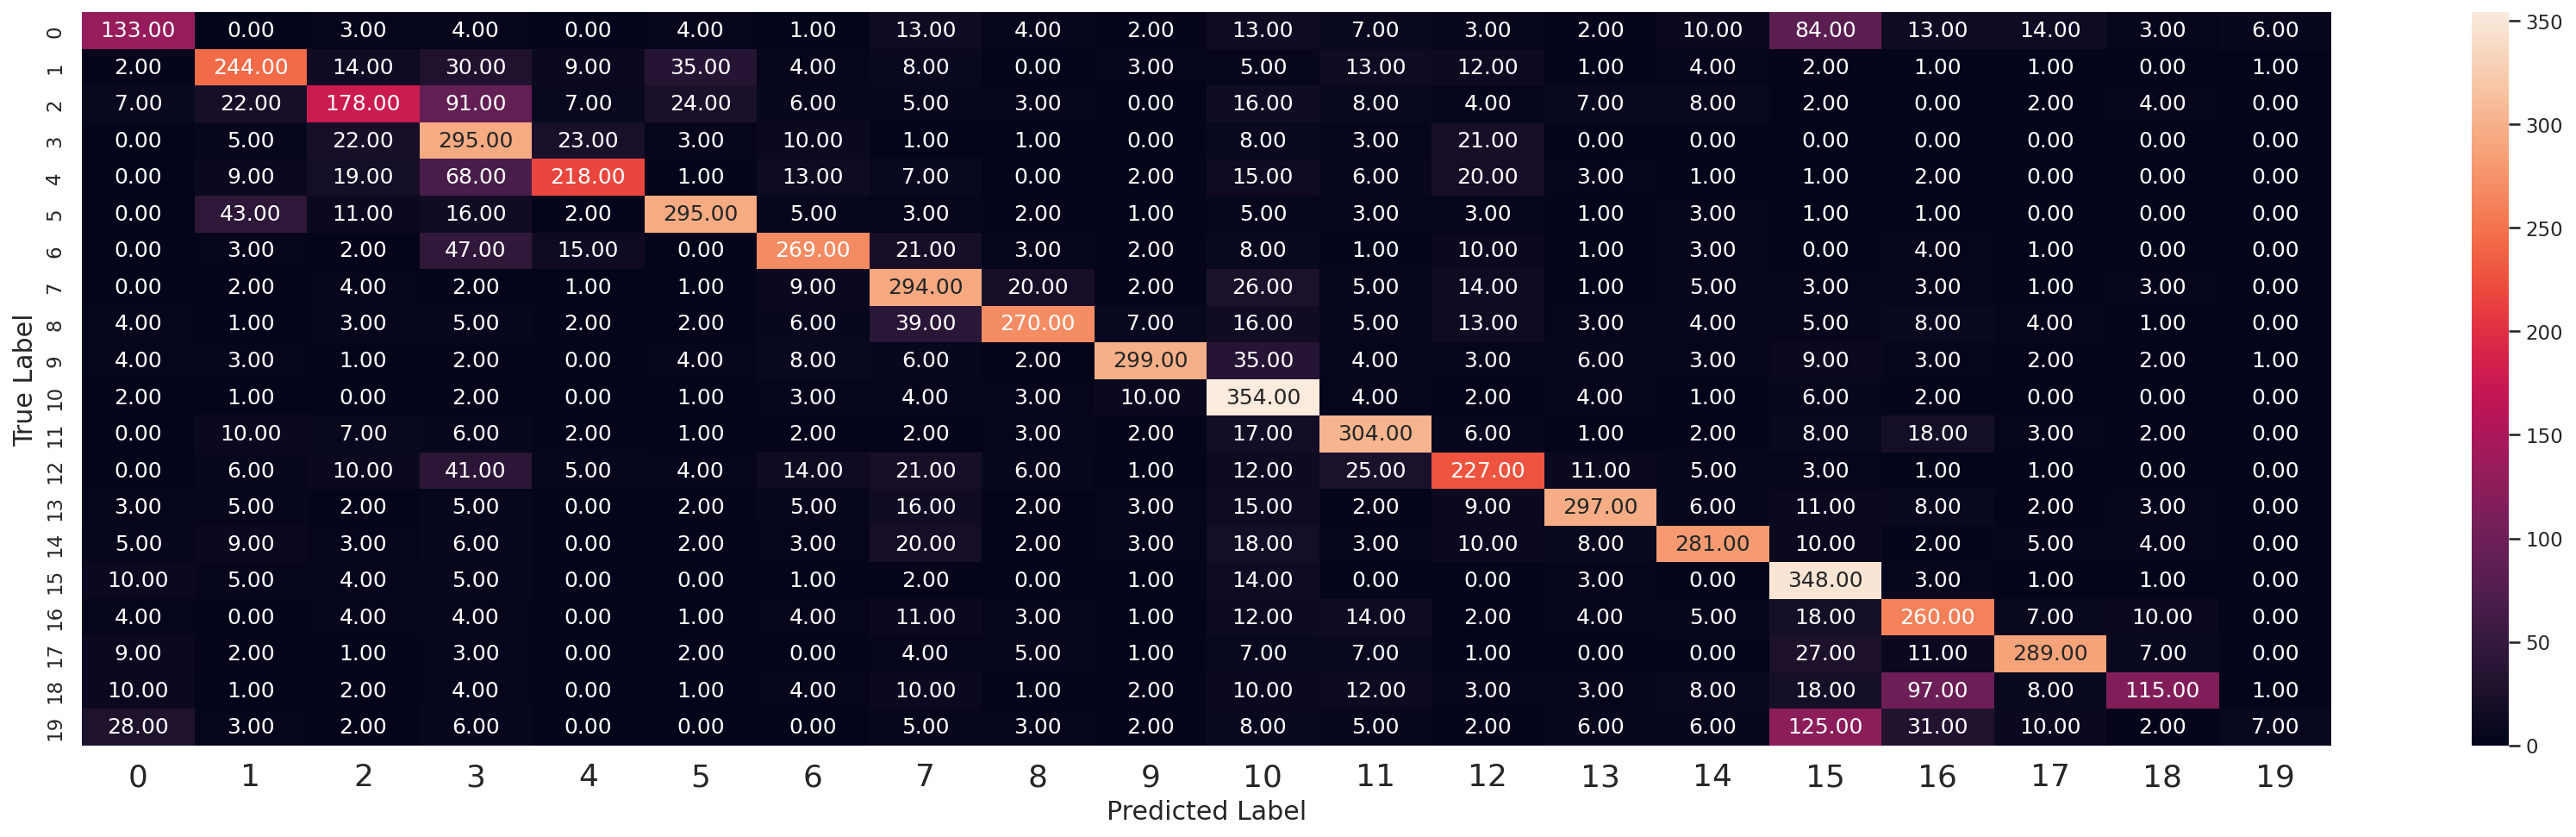

In [26]:
nbc_confusion_matrix = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(nbc_confusion_matrix, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [27]:
from sklearn.metrics import classification_report

In [28]:
nbc_metric = classification_report(y_test, y_test_pred, target_names = categories)
print(nbc_metric)

                          precision    recall  f1-score   support

             alt.atheism       0.60      0.42      0.49       319
           comp.graphics       0.65      0.63      0.64       389
 comp.os.ms-windows.misc       0.61      0.45      0.52       394
comp.sys.ibm.pc.hardware       0.46      0.75      0.57       392
   comp.sys.mac.hardware       0.77      0.57      0.65       385
          comp.windows.x       0.77      0.75      0.76       395
            misc.forsale       0.73      0.69      0.71       390
               rec.autos       0.60      0.74      0.66       396
         rec.motorcycles       0.81      0.68      0.74       398
      rec.sport.baseball       0.87      0.75      0.81       397
        rec.sport.hockey       0.58      0.89      0.70       399
               sci.crypt       0.71      0.77      0.74       396
         sci.electronics       0.62      0.58      0.60       393
                 sci.med       0.82      0.75      0.78       396
         

In [29]:
nbc_train_metric = classification_report(y_train, y_pred, target_names = categories)
print(nbc_train_metric)

                          precision    recall  f1-score   support

             alt.atheism       0.98      0.91      0.94       480
           comp.graphics       0.96      0.92      0.94       584
 comp.os.ms-windows.misc       0.95      0.90      0.93       591
comp.sys.ibm.pc.hardware       0.90      0.95      0.92       590
   comp.sys.mac.hardware       0.98      0.93      0.95       578
          comp.windows.x       0.96      0.97      0.96       593
            misc.forsale       0.97      0.93      0.95       585
               rec.autos       0.98      0.92      0.95       594
         rec.motorcycles       0.99      0.95      0.97       598
      rec.sport.baseball       0.99      0.95      0.97       597
        rec.sport.hockey       0.66      0.98      0.79       600
               sci.crypt       0.96      0.95      0.96       595
         sci.electronics       0.98      0.93      0.95       591
                 sci.med       0.98      0.96      0.97       594
         

### Suppport Vector Machine

In [30]:
from sklearn.svm import LinearSVC

In [31]:
svc = LinearSVC(dual=False) # Intializing dual to false since no_of_features < no_of_samples
svc.fit(x, y_train)

LinearSVC(dual=False)

In [32]:
svm_train_pred = svc.predict(x)
svm_train_pred

array([7, 4, 4, ..., 3, 1, 8])

In [33]:
svm_test_pred = svc.predict(x_test)
svm_test_pred

array([ 3,  1,  3, ...,  9, 12,  0])

In [34]:
svc_train_accuracy = accuracy_score(y_train, svm_train_pred)
print('SVM Train accuracy: ', svc_train_accuracy)

SVM Train accuracy:  0.9711861410641683


In [35]:
svc_test_accuracy = accuracy_score(y_test, svm_test_pred)
print('SVM Test accuracy: ', svc_test_accuracy)

SVM Test accuracy:  0.6479022835900159


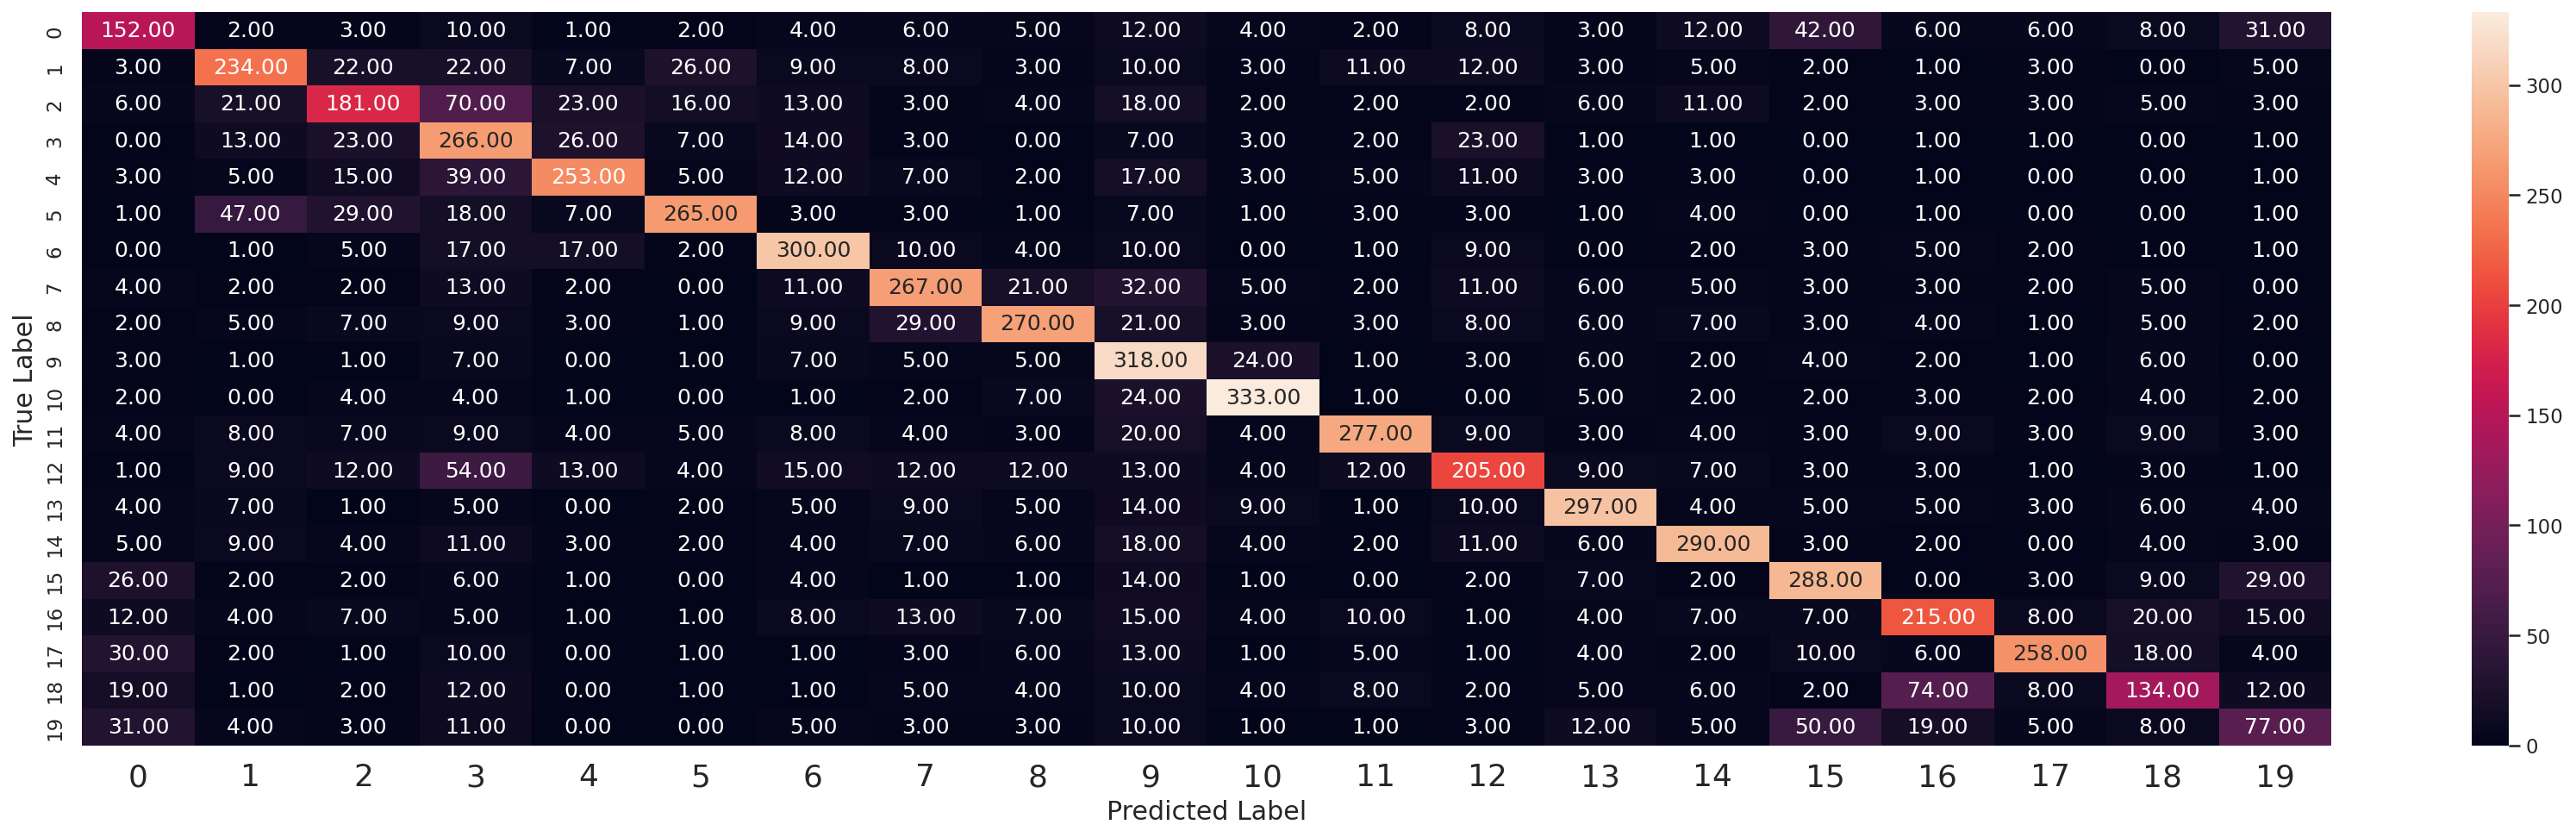

In [36]:
svc_confusion_matrix = confusion_matrix(y_test, svm_test_pred)
ax = sns.heatmap(svc_confusion_matrix, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [37]:
svc_train_metric = classification_report(y_train, svm_train_pred, target_names = categories)
print(svc_train_metric)

                          precision    recall  f1-score   support

             alt.atheism       1.00      0.97      0.99       480
           comp.graphics       0.99      0.96      0.98       584
 comp.os.ms-windows.misc       0.99      0.95      0.97       591
comp.sys.ibm.pc.hardware       0.99      0.97      0.98       590
   comp.sys.mac.hardware       0.99      0.96      0.98       578
          comp.windows.x       1.00      0.99      1.00       593
            misc.forsale       0.99      0.98      0.99       585
               rec.autos       0.99      0.94      0.97       594
         rec.motorcycles       1.00      0.97      0.98       598
      rec.sport.baseball       0.67      1.00      0.80       597
        rec.sport.hockey       1.00      0.97      0.98       600
               sci.crypt       1.00      0.98      0.99       595
         sci.electronics       1.00      0.96      0.98       591
                 sci.med       1.00      0.97      0.99       594
         

In [38]:
svc_test_metric = classification_report(y_test, svm_test_pred, target_names = categories)
print(svc_test_metric)

                          precision    recall  f1-score   support

             alt.atheism       0.49      0.48      0.48       319
           comp.graphics       0.62      0.60      0.61       389
 comp.os.ms-windows.misc       0.55      0.46      0.50       394
comp.sys.ibm.pc.hardware       0.44      0.68      0.54       392
   comp.sys.mac.hardware       0.70      0.66      0.68       385
          comp.windows.x       0.78      0.67      0.72       395
            misc.forsale       0.69      0.77      0.73       390
               rec.autos       0.67      0.67      0.67       396
         rec.motorcycles       0.73      0.68      0.70       398
      rec.sport.baseball       0.53      0.80      0.64       397
        rec.sport.hockey       0.81      0.83      0.82       399
               sci.crypt       0.79      0.70      0.74       396
         sci.electronics       0.61      0.52      0.56       393
                 sci.med       0.77      0.75      0.76       396
         

### K-Nearest Neighbour

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x, y_train)

KNeighborsClassifier(n_neighbors=3)

In [41]:
knn_train_pred = knn.predict(x)
knn_train_pred

array([4, 4, 4, ..., 4, 4, 4])

In [42]:
knn_test_pred = knn.predict(x_test)
knn_test_pred

array([4, 4, 4, ..., 4, 4, 4])

In [43]:
knn_train_accuracy = accuracy_score(y_train, knn_train_pred)
print('KNN Train accuracy: ', knn_train_accuracy)

KNN Train accuracy:  0.18428495669082554


In [44]:
knn_test_accuracy = accuracy_score(y_test, knn_test_pred)
print('KNN Test accuracy: ', knn_test_accuracy)

KNN Test accuracy:  0.06213489113117366


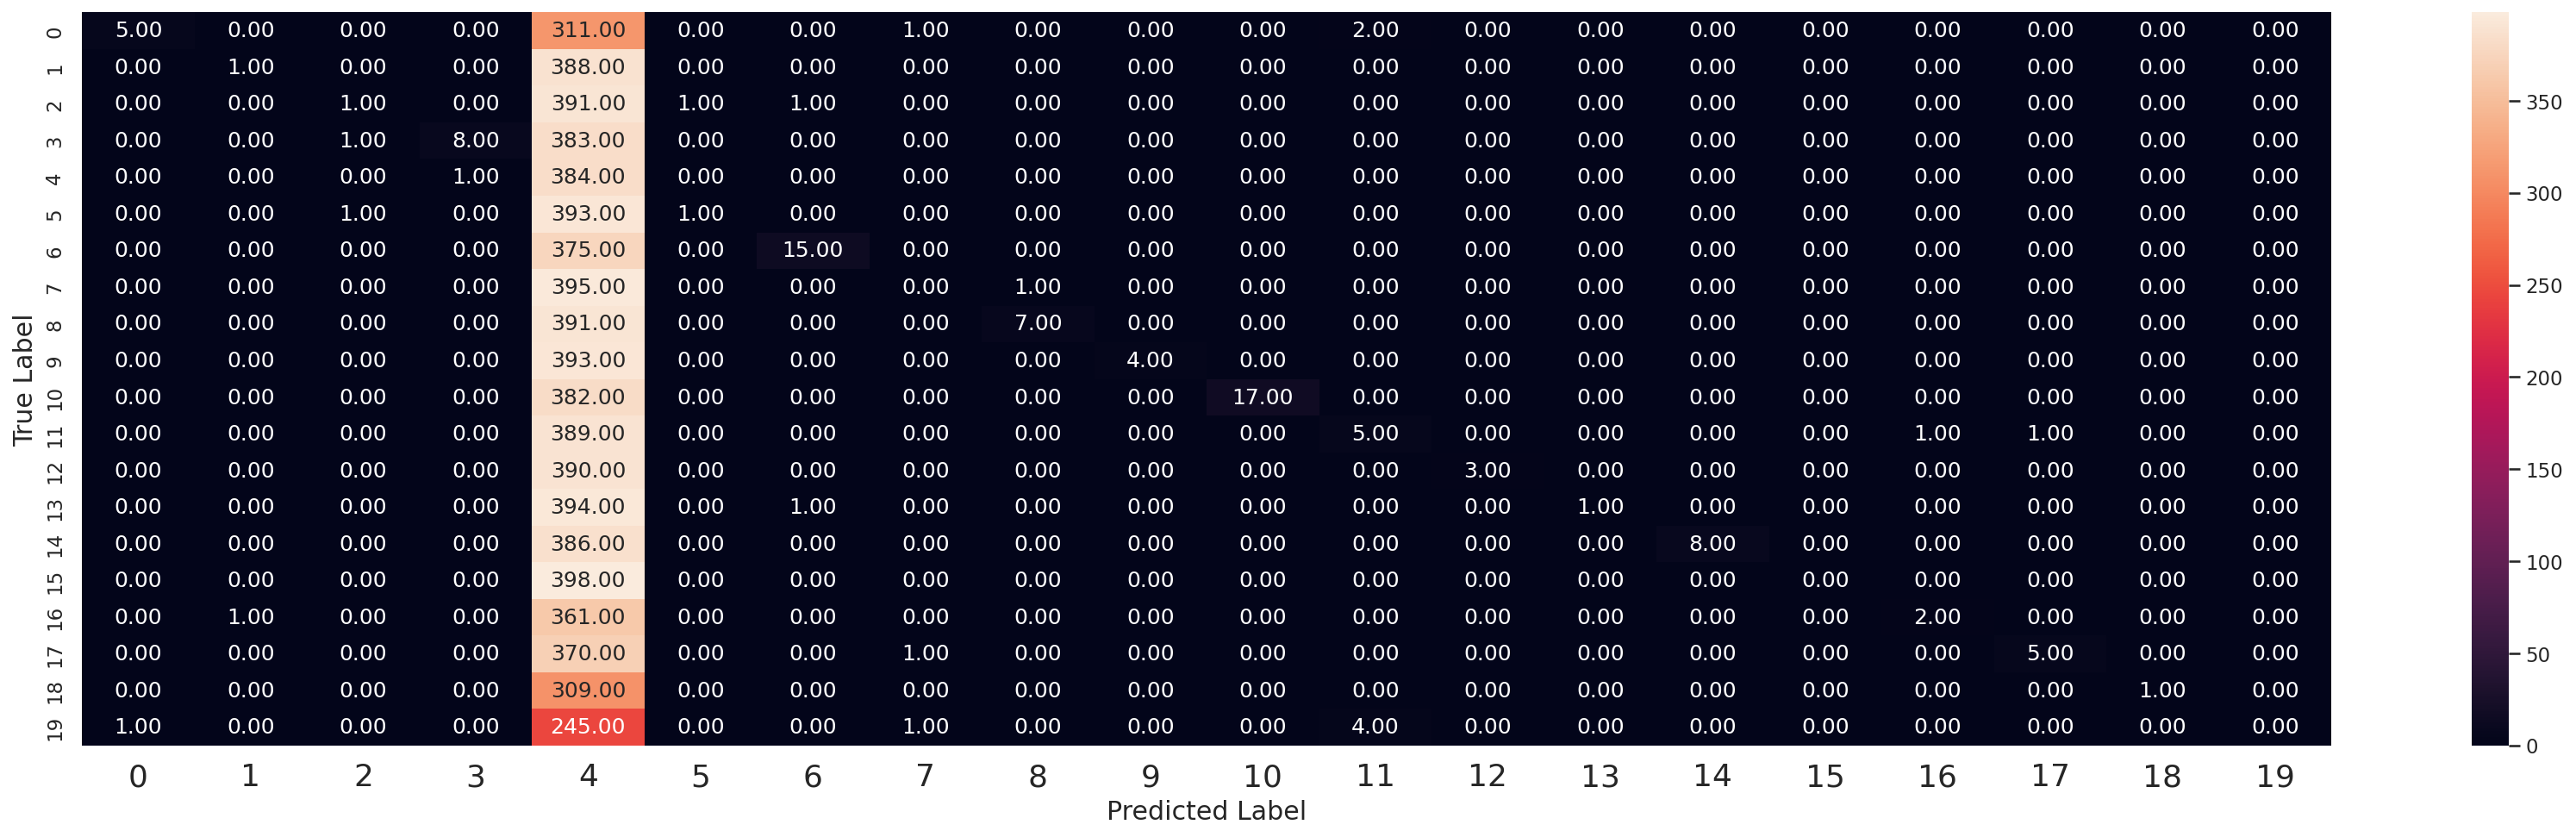

In [45]:
knn_confusion_matrix = confusion_matrix(y_test, knn_test_pred)
ax = sns.heatmap(knn_confusion_matrix, annot=True,fmt='.2f')
ax.set_xlabel('Predicted Label');
ax.set_ylabel('True Label');

In [46]:
knn_train_metric = classification_report(y_train, knn_train_pred, target_names = categories)
print(knn_train_metric)

                          precision    recall  f1-score   support

             alt.atheism       0.91      0.12      0.22       480
           comp.graphics       0.87      0.12      0.21       584
 comp.os.ms-windows.misc       0.96      0.21      0.35       591
comp.sys.ibm.pc.hardware       0.91      0.14      0.25       590
   comp.sys.mac.hardware       0.06      0.99      0.11       578
          comp.windows.x       1.00      0.24      0.38       593
            misc.forsale       1.00      0.11      0.20       585
               rec.autos       0.92      0.06      0.11       594
         rec.motorcycles       1.00      0.11      0.19       598
      rec.sport.baseball       1.00      0.08      0.14       597
        rec.sport.hockey       0.99      0.17      0.30       600
               sci.crypt       0.98      0.19      0.32       595
         sci.electronics       0.97      0.16      0.27       591
                 sci.med       0.99      0.19      0.32       594
         

In [47]:
knn_test_metric = classification_report(y_test, knn_test_pred, target_names = categories)
print(knn_test_metric)

                          precision    recall  f1-score   support

             alt.atheism       0.83      0.02      0.03       319
           comp.graphics       0.50      0.00      0.01       389
 comp.os.ms-windows.misc       0.33      0.00      0.01       394
comp.sys.ibm.pc.hardware       0.89      0.02      0.04       392
   comp.sys.mac.hardware       0.05      1.00      0.10       385
          comp.windows.x       0.50      0.00      0.01       395
            misc.forsale       0.88      0.04      0.07       390
               rec.autos       0.00      0.00      0.00       396
         rec.motorcycles       0.88      0.02      0.03       398
      rec.sport.baseball       1.00      0.01      0.02       397
        rec.sport.hockey       1.00      0.04      0.08       399
               sci.crypt       0.45      0.01      0.02       396
         sci.electronics       1.00      0.01      0.02       393
                 sci.med       1.00      0.00      0.01       396
         

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
model_train_accuracies = []
model_train_accuracies.append(nbc_train_accuracy)
model_train_accuracies.append(svc_train_accuracy)
model_train_accuracies.append(knn_train_accuracy)
model_train_accuracies = [i*100  for i in model_train_accuracies]
model_train_accuracies

[93.46826940074244, 97.11861410641683, 18.428495669082555]

In [58]:
model_test_accuracies = []
model_test_accuracies.append(nbc_test_accuracy)
model_test_accuracies.append(svc_test_accuracy)
model_test_accuracies.append(knn_test_accuracy)
model_test_accuracies = [i*100  for i in model_test_accuracies]
model_test_accuracies

[66.07806691449815, 64.79022835900159, 6.213489113117366]

In [61]:
all_models = ['Naive Bayes Classifier', 'Support Vector Machine', 'K Nearest Neighbour']

In [63]:
models = pd.DataFrame({'Models' : all_models, 'Model Training Accuracy' : model_train_accuracies, 
                       'Model Testing Accuracy: ': model_test_accuracies})
models

,Models,Model Training Accuracy,Model Testing Accuracy:
0,Naive Bayes Classifier,93.468269,66.078067
1,Support Vector Machine,97.118614,64.790228
2,K Nearest Neighbour,18.428496,6.213489


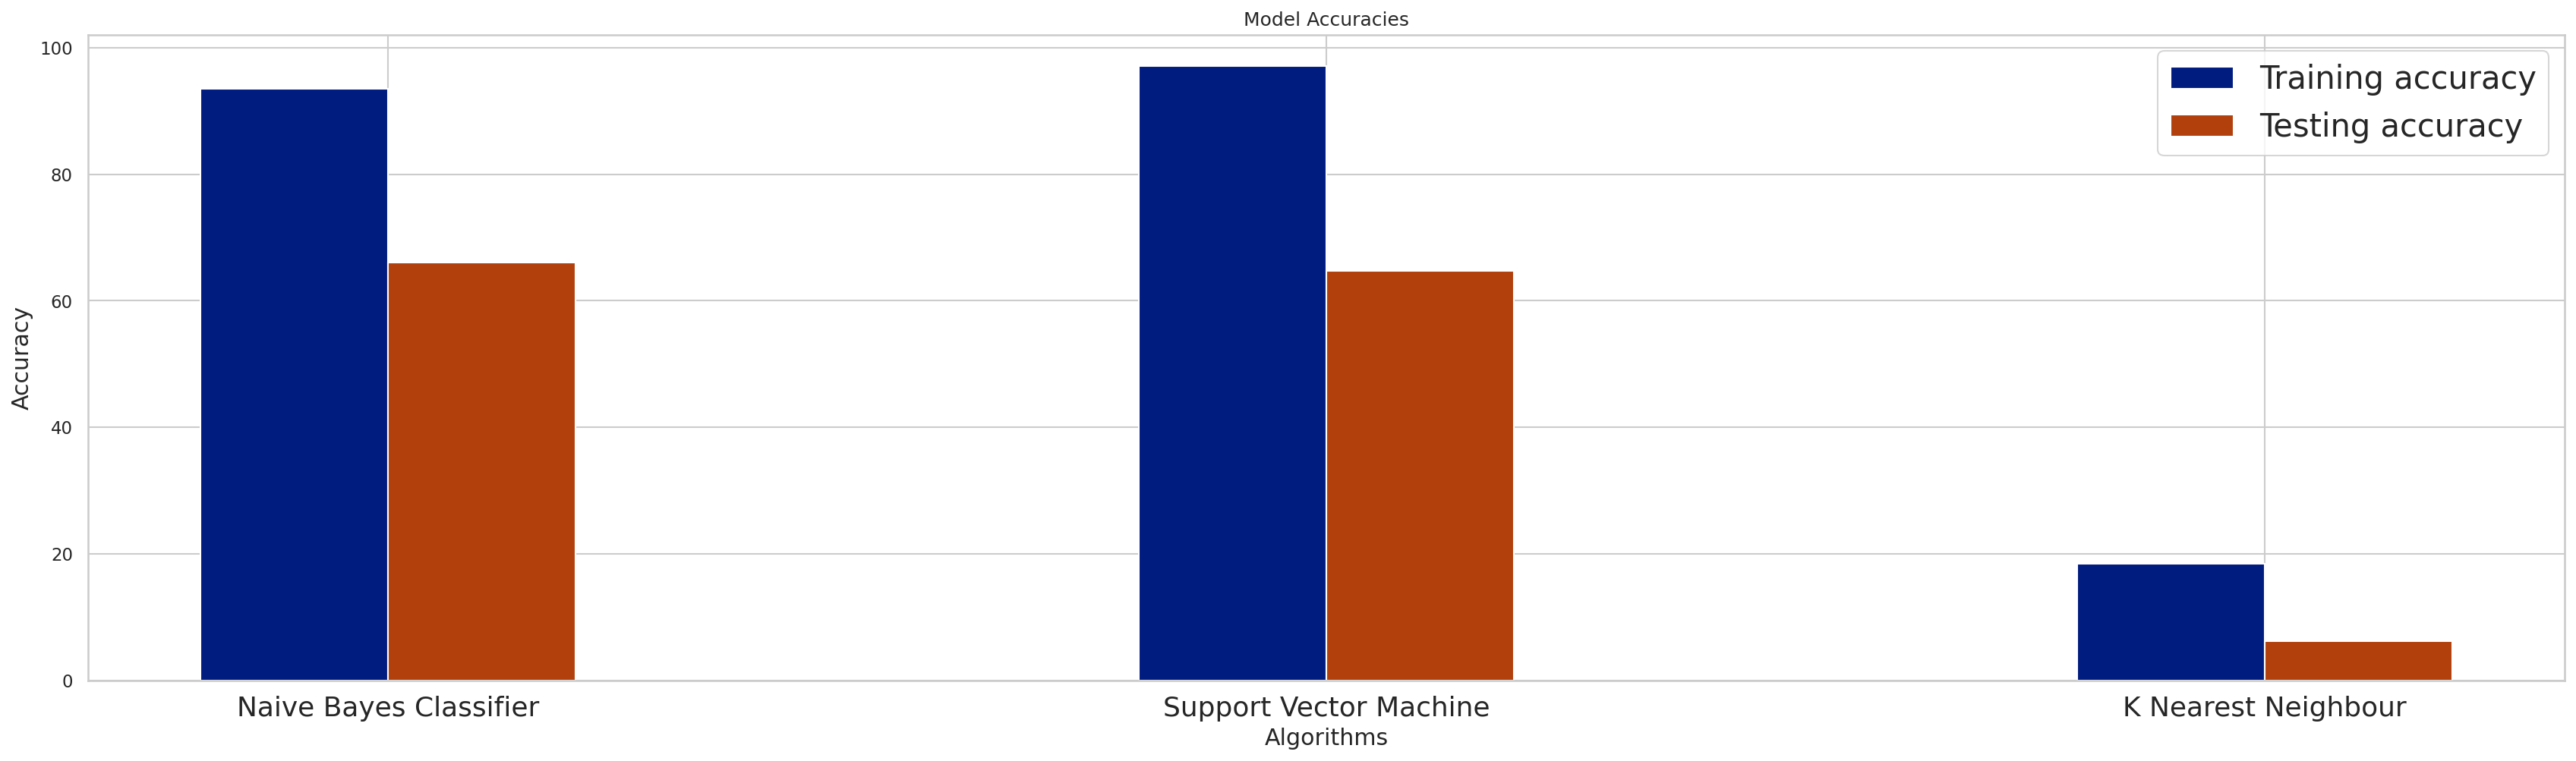

In [69]:
w = 0.2
b1 = np.arange(len(all_models))
b2 = [i+w for i in b1]

plt.bar(b1, model_train_accuracies, w, label='Training accuracy')
plt.bar(b2, model_test_accuracies, w, label='Testing accuracy')
plt.title("Model Accuracies")
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.xticks(b1+w/2,all_models)
plt.legend()
plt.show()